In [5]:
import numpy as np
import pandas as pd
import datetime
import os
import shutil
import re
import math
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage import img_as_float32, img_as_ubyte

import cv2

from albumentations import (
    Compose, HorizontalFlip, ShiftScaleRotate, ElasticTransform,
    RandomBrightness, RandomContrast, RandomGamma
)

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [6]:
%matplotlib inline

In [7]:
root_folder = "../1_data/3_Images"
masks_folder = os.path.join(root_folder, "masks")

img_size = 400

In [8]:
images = []
labels = []
manual_images = []
v7labs_images = []

for mask_path in os.listdir(masks_folder):
  mask = imread(os.path.join(masks_folder, mask_path))
  mask = np.float32(mask / 255)
  labels.append(mask)
  target, source, pathogen, pid, offset, _ = re.split("[_.]", mask_path)
  img_path = "%s_%s_%s_%s.png" % (source, pathogen, pid, offset)
  img = imread(os.path.join(root_folder, target, pathogen, img_path))
  img = img_as_float32(img)
  
  if source == "Cohen":
    v7labs_images.append(img)
  else:
    manual_images.append(img)
  
  images.append(img)
  
len(labels)

700

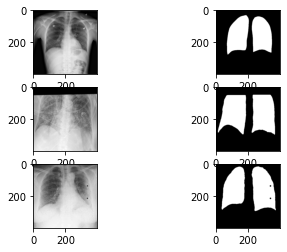

In [9]:
# Show some of our own CXR and masks
f = plt.figure()
f.add_subplot(3, 2, 1)
plt.imshow(images[50], cmap = "gray")
f.add_subplot(3, 2, 2)
plt.imshow(labels[50], cmap = "gray")
f.add_subplot(3, 2, 3)
plt.imshow(images[20], cmap = "gray")
f.add_subplot(3, 2, 4)
plt.imshow(labels[20], cmap = "gray")
f.add_subplot(3, 2, 5)
plt.imshow(images[30], cmap = "gray")
f.add_subplot(3, 2, 6)
plt.imshow(labels[30], cmap = "gray")

In [10]:
# Also load the Montgomery dataset that already contains manually segmented masks
montgomery_images = []
montgomery_labels = []
montgomery_folder = "1_extra_datasets/Montgomery/processed"
for img_path in os.listdir(os.path.join(montgomery_folder, "CXR")):
  img = imread(os.path.join(montgomery_folder, "CXR", img_path))
  img = img_as_float32(img)
  montgomery_images.append(img)
  images.append(img)
  
  mask = imread(os.path.join(montgomery_folder, "Masks", img_path))
  mask = np.float32(mask / 255)
  montgomery_labels.append(mask)
  labels.append(mask)

len(montgomery_labels)

138

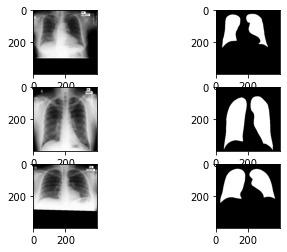

In [11]:
f = plt.figure()
f.add_subplot(3, 2, 1)
plt.imshow(montgomery_images[10], cmap = "gray")
f.add_subplot(3, 2, 2)
plt.imshow(montgomery_labels[10], cmap = "gray")
f.add_subplot(3, 2, 3)
plt.imshow(montgomery_images[20], cmap = "gray")
f.add_subplot(3, 2, 4)
plt.imshow(montgomery_labels[20], cmap = "gray")
f.add_subplot(3, 2, 5)
plt.imshow(montgomery_images[30], cmap = "gray")
f.add_subplot(3, 2, 6)
plt.imshow(montgomery_labels[30], cmap = "gray")

In [12]:
# Also load the JSRT dataset that already contains manually segmented masks
jsrt_images = []
jsrt_labels = []
jsrt_folder = "1_extra_datasets/JSRT/processed"
for img_path in os.listdir(os.path.join(jsrt_folder, "CXR")):
  img = imread(os.path.join(jsrt_folder, "CXR", img_path))
  img = img_as_float32(img)
  jsrt_images.append(img)
  images.append(img)
  
  mask = imread(os.path.join(jsrt_folder, "Masks", img_path))
  mask = np.float32(mask / 255)
  jsrt_labels.append(mask)
  labels.append(mask)

len(jsrt_labels)

247

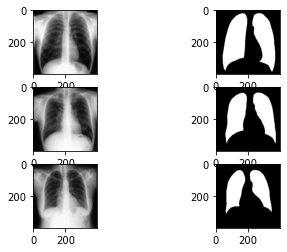

In [13]:
f = plt.figure()
f.add_subplot(3, 2, 1)
plt.imshow(jsrt_images[10], cmap = "gray")
f.add_subplot(3, 2, 2)
plt.imshow(jsrt_labels[10], cmap = "gray")
f.add_subplot(3, 2, 3)
plt.imshow(jsrt_images[20], cmap = "gray")
f.add_subplot(3, 2, 4)
plt.imshow(jsrt_labels[20], cmap = "gray")
f.add_subplot(3, 2, 5)
plt.imshow(jsrt_images[30], cmap = "gray")
f.add_subplot(3, 2, 6)
plt.imshow(jsrt_labels[30], cmap = "gray")

In [14]:
# Also load the Shenzhen dataset that already contains manually segmented masks
shenzhen_images = []
shenzhen_labels = []
shenzhen_folder = "1_extra_datasets/Shenzhen/processed"
for img_path in os.listdir(os.path.join(shenzhen_folder, "CXR")):
  img = imread(os.path.join(shenzhen_folder, "CXR", img_path))
  img = img_as_float32(img)
  shenzhen_images.append(img)
  images.append(img)
  
  mask = imread(os.path.join(shenzhen_folder, "Masks", img_path))
  mask = np.float32(mask / 255)
  shenzhen_labels.append(mask)
  labels.append(mask)

len(shenzhen_labels)

566

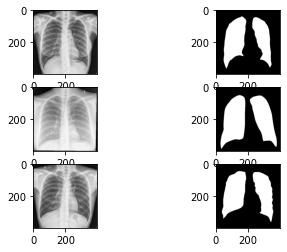

In [15]:
f = plt.figure()
f.add_subplot(3, 2, 1)
plt.imshow(shenzhen_images[10], cmap = "gray")
f.add_subplot(3, 2, 2)
plt.imshow(shenzhen_labels[10], cmap = "gray")
f.add_subplot(3, 2, 3)
plt.imshow(shenzhen_images[20], cmap = "gray")
f.add_subplot(3, 2, 4)
plt.imshow(shenzhen_labels[20], cmap = "gray")
f.add_subplot(3, 2, 5)
plt.imshow(shenzhen_images[30], cmap = "gray")
f.add_subplot(3, 2, 6)
plt.imshow(shenzhen_labels[30], cmap = "gray")

In [16]:
X = np.array(images).reshape((len(images), img_size, img_size, 1))
Y = np.array(labels).reshape((len(labels), img_size, img_size, 1))
X, Y = shuffle(X, Y, random_state = 1234)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.05, random_state = 1234)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.05, random_state = 1234)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X.shape)

(1489, 400, 400, 1)
(79, 400, 400, 1)
(83, 400, 400, 1)
(1651, 400, 400, 1)


In [17]:
shenzhen_test_ids = []
jsrt_test_ids = []
montgomery_test_ids = []
v7labs_test_ids = []
other_test_ids = []

nimages = X_test.shape[0]
for idx in range(nimages):
  test_image = X_test[idx,:,:,0]
  if any(np.array_equal(test_image, x) for x in shenzhen_images):
    shenzhen_test_ids.append(idx)
  elif any(np.array_equal(test_image, x) for x in montgomery_images):
    montgomery_test_ids.append(idx)
  elif any(np.array_equal(test_image, x) for x in jsrt_images):
    jsrt_test_ids.append(idx)
  elif any(np.array_equal(test_image, x) for x in v7labs_images):
    v7labs_test_ids.append(idx)
  else:
    other_test_ids.append(idx)

In [18]:
class AugmentationSequence(keras.utils.Sequence):
  def __init__(self, x_set, y_set, batch_size, augmentations):
    self.x, self.y = x_set, y_set
    self.batch_size = batch_size
    self.augment = augmentations

  def __len__(self):
    return int(np.ceil(len(self.x) / float(self.batch_size)))

  def __getitem__(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
    
    aug_x = np.zeros(batch_x.shape)
    aug_y = np.zeros(batch_y.shape)
    
    for idx in range(batch_x.shape[0]):
      aug = self.augment(image = batch_x[idx,:,:,:], mask = batch_y[idx,:,:,:])
      aug_x[idx,:,:,:] = aug["image"]
      aug_y[idx,:,:,:] = aug["mask"]
    
    return aug_x, aug_y

augment = Compose([
  HorizontalFlip(),
  ShiftScaleRotate(rotate_limit = 45, border_mode = cv2.BORDER_CONSTANT),
  ElasticTransform(border_mode = cv2.BORDER_CONSTANT),
  RandomBrightness(),
  RandomContrast(),
  RandomGamma()
])

batch_size = 16
train_generator = AugmentationSequence(X_train, Y_train, batch_size, augment)
steps_per_epoch = math.ceil(X_train.shape[0] / batch_size)

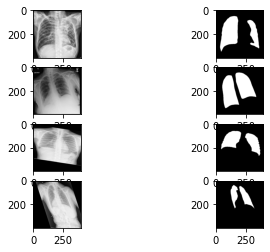

In [19]:
X_aug, Y_aug = train_generator.__getitem__(20)

f = plt.figure()
f.add_subplot(4, 2, 1)
plt.imshow(X_aug[0,:,:,0], cmap = "gray")
f.add_subplot(4, 2, 2)
plt.imshow(Y_aug[0,:,:,0], cmap = "gray")

f.add_subplot(4, 2, 3)
plt.imshow(X_aug[1,:,:,0], cmap = "gray")
f.add_subplot(4, 2, 4)
plt.imshow(Y_aug[1,:,:,0], cmap = "gray")

f.add_subplot(4, 2, 5)
plt.imshow(X_aug[2,:,:,0], cmap = "gray")
f.add_subplot(4, 2, 6)
plt.imshow(Y_aug[2,:,:,0], cmap = "gray")

f.add_subplot(4, 2, 7)
plt.imshow(X_aug[3,:,:,0], cmap = "gray")
f.add_subplot(4, 2, 8)
plt.imshow(Y_aug[3,:,:,0], cmap = "gray")

In [20]:
# LOSS Functions
def jaccard_distance_loss(y_true, y_pred, smooth = 100):
    intersection = keras.backend.sum(keras.backend.abs(y_true * y_pred), axis = -1)
    union = keras.backend.sum(keras.backend.abs(y_true) + keras.backend.abs(y_pred), axis = -1)
    jac = (intersection + smooth) / (union - intersection + smooth)
    loss = (1 - jac) * smooth
    return loss

def dice_coef(y_true, y_pred, smooth = 1):
    intersection = keras.backend.sum(keras.backend.abs(y_true * y_pred), axis = -1)
    union = keras.backend.sum(keras.backend.abs(y_true), -1) + keras.backend.sum(keras.backend.abs(y_pred), -1)
    return (2. * intersection + smooth) / (union + smooth)

In [21]:
def unet_model():
  
  input_img = keras.layers.Input((img_size, img_size, 1), name = "img")
  
  # Contract #1
  c1 = keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(input_img)
  c1 = keras.layers.BatchNormalization()(c1)
  c1 = keras.layers.Activation("relu")(c1)
  c1 = keras.layers.Dropout(0.1)(c1)
  c1 = keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c1)
  c1 = keras.layers.BatchNormalization()(c1)
  c1 = keras.layers.Activation("relu")(c1)
  p1 = keras.layers.MaxPooling2D((2, 2))(c1)
  
  # Contract #2
  c2 = keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p1)
  c2 = keras.layers.BatchNormalization()(c2)
  c2 = keras.layers.Activation("relu")(c2)
  c2 = keras.layers.Dropout(0.2)(c2)
  c2 = keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c2)
  c2 = keras.layers.BatchNormalization()(c2)
  c2 = keras.layers.Activation("relu")(c2)
  p2 = keras.layers.MaxPooling2D((2, 2))(c2)
  
  # Contract #3
  c3 = keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p2)
  c3 = keras.layers.BatchNormalization()(c3)
  c3 = keras.layers.Activation("relu")(c3)
  c3 = keras.layers.Dropout(0.3)(c3)
  c3 = keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c3)
  c3 = keras.layers.BatchNormalization()(c3)
  c3 = keras.layers.Activation("relu")(c3)
  p3 = keras.layers.MaxPooling2D((2, 2))(c3)
  
  # Contract #4
  c4 = keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p3)
  c4 = keras.layers.BatchNormalization()(c4)
  c4 = keras.layers.Activation("relu")(c4)
  c4 = keras.layers.Dropout(0.4)(c4)
  c4 = keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c4)
  c4 = keras.layers.BatchNormalization()(c4)
  c4 = keras.layers.Activation("relu")(c4)
  p4 = keras.layers.MaxPooling2D((2, 2))(c4)
  
  # Middle
  c5 = keras.layers.Conv2D(256, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p4)
  c5 = keras.layers.BatchNormalization()(c5)
  c5 = keras.layers.Activation("relu")(c5)
  c5 = keras.layers.Dropout(0.5)(c5)
  c5 = keras.layers.Conv2D(256, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c5)
  c5 = keras.layers.BatchNormalization()(c5)
  c5 = keras.layers.Activation("relu")(c5)
  
  # Expand (upscale) #1
  u6 = keras.layers.Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = "same")(c5)
  u6 = keras.layers.concatenate([u6, c4])
  c6 = keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u6)
  c6 = keras.layers.BatchNormalization()(c6)
  c6 = keras.layers.Activation("relu")(c6)
  c6 = keras.layers.Dropout(0.5)(c6)
  c6 = keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c6)
  c6 = keras.layers.BatchNormalization()(c6)
  c6 = keras.layers.Activation("relu")(c6)
  
  # Expand (upscale) #2
  u7 = keras.layers.Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = "same")(c6)
  u7 = keras.layers.concatenate([u7, c3])
  c7 = keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u7)
  c7 = keras.layers.BatchNormalization()(c7)
  c7 = keras.layers.Activation("relu")(c7)
  c7 = keras.layers.Dropout(0.5)(c7)
  c7 = keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c7)
  c7 = keras.layers.BatchNormalization()(c7)
  c7 = keras.layers.Activation("relu")(c7)
  
  # Expand (upscale) #3
  u8 = keras.layers.Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = "same")(c7)
  u8 = keras.layers.concatenate([u8, c2])
  c8 = keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u8)
  c8 = keras.layers.BatchNormalization()(c8)
  c8 = keras.layers.Activation("relu")(c8)
  c8 = keras.layers.Dropout(0.5)(c8)
  c8 = keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c8)
  c8 = keras.layers.BatchNormalization()(c8)
  c8 = keras.layers.Activation("relu")(c8)
  
  # Expand (upscale) #4
  u9 = keras.layers.Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = "same")(c8)
  u9 = keras.layers.concatenate([u9, c1])
  c9 = keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u9)
  c9 = keras.layers.BatchNormalization()(c9)
  c9 = keras.layers.Activation("relu")(c9)
  c9 = keras.layers.Dropout(0.5)(c9)
  c9 = keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c9)
  c9 = keras.layers.BatchNormalization()(c9)
  c9 = keras.layers.Activation("relu")(c9)
  
  output = keras.layers.Conv2D(1, (1, 1), activation = "sigmoid")(c9)
  model = keras.Model(inputs = [input_img], outputs = [output])
  return model

In [22]:
reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(
  monitor = "loss", 
  factor = 0.5, 
  patience = 3, 
  verbose = 1
)

checkpointer = keras.callbacks.ModelCheckpoint(
  "unet.h5", 
  verbose = 1, 
  save_best_only = True
)

strategy = tf.distribute.MirroredStrategy()

if (os.path.exists("unet.h5")):
  model = keras.models.load_model("unet.h5",
    custom_objects = {
      "jaccard_distance_loss": jaccard_distance_loss,
      "dice_coef": dice_coef
    }
  )
  
else:
  with strategy.scope():
    model = unet_model()
    adam_opt = keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(optimizer = adam_opt, loss = jaccard_distance_loss, metrics = [dice_coef])
    
  fit = model.fit(train_generator, 
    steps_per_epoch = steps_per_epoch, 
    epochs = 100,
    validation_data = (X_val, Y_val),
    callbacks = [
      checkpointer,
      reduce_learning_rate
    ]
  )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 400, 400, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 400, 400, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 400, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 400, 400, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [24]:
iou_train, dice_train = model.evaluate(X_train, Y_train, verbose = False)
iou_val, dice_val = model.evaluate(X_val, Y_val, verbose = False)
iou_test, dice_test = model.evaluate(X_test, Y_test, verbose = False)

print("Jaccard distance (IoU) train: %f" % iou_train)
print("Dice coeffient train: %f" % dice_train)
print("Jaccard distance (IoU) validation: %f" % iou_val)
print("Dice coeffient validation: %f" % dice_val)
print("Jaccard distance (IoU) test: %f" % iou_test)
print("Dice coeffient test: %f" % dice_test)

Jaccard distance (IoU) train: 0.029748
Dice coeffient train: 0.984873
Jaccard distance (IoU) validation: 0.027380
Dice coeffient validation: 0.986081
Jaccard distance (IoU) test: 0.028626
Dice coeffient test: 0.985445


In [25]:
nimages = X_train.shape[0]
iou_train = []
dice_train = []
for idx in range(nimages):
  iou, dice = model.evaluate(X_train[idx:idx+1,:,:], Y_train[idx:idx+1,:,:], verbose = False)
  iou_train.append(iou)
  dice_train.append(dice)

print("Jaccard distance (IoU) train: %f (+-%f)" % (np.mean(iou_train), np.std(iou_train)))
print("Dice coeffient train: %f (+-%f)" % (np.mean(dice_train), np.std(dice_train)))

nimages = X_val.shape[0]
iou_val = []
dice_val = []
for idx in range(nimages):
  iou, dice = model.evaluate(X_val[idx:idx+1,:,:], Y_val[idx:idx+1,:,:], verbose = False)
  iou_val.append(iou)
  dice_val.append(dice)

print("Jaccard distance (IoU) validation: %f (+-%f)" % (np.mean(iou_val), np.std(iou_val)))
print("Dice coeffient validation: %f (+-%f)" % (np.mean(dice_val), np.std(dice_val)))


nimages = X_test.shape[0]
iou_test = []
dice_test = []
for idx in range(nimages):
  iou, dice = model.evaluate(X_test[idx:idx+1,:,:], Y_test[idx:idx+1,:,:], verbose = False)
  iou_test.append(iou)
  dice_test.append(dice)

print("Jaccard distance (IoU) test: %f (+-%f)" % (np.mean(iou_test), np.std(iou_test)))
print("Dice coeffient test: %f (+-%f)" % (np.mean(dice_test), np.std(dice_test)))


Jaccard distance (IoU) train: 0.029748 (+-0.028464)
Dice coeffient train: 0.984873 (+-0.014380)
Jaccard distance (IoU) validation: 0.027380 (+-0.021211)
Dice coeffient validation: 0.986081 (+-0.010707)
Jaccard distance (IoU) test: 0.028626 (+-0.022382)
Dice coeffient test: 0.985445 (+-0.011300)


In [21]:
nimages = X_test.shape[0]
iou_test = []
dice_test = []
with tf.device("/gpu:1"):
  for idx in range(nimages):
    iou, dice = model.evaluate(X_test[idx:idx+1,:,:], Y_test[idx:idx+1,:,:], verbose = False)
    iou_test.append(iou)
    dice_test.append(dice)

print("Jaccard distance (IoU) test: %f (+-%f)" % (np.mean(iou_test), np.std(iou_test)))
print("Dice coeffient test: %f (+-%f)" % (np.mean(dice_test), np.std(dice_test)))


iou_shenzhen = []
dice_shenzhen = []
with tf.device("/gpu:1"):
  for idx in shenzhen_test_ids:
    iou, dice = model.evaluate(X_test[idx:idx+1,:,:], Y_test[idx:idx+1,:,:], verbose = False)
    iou_shenzhen.append(iou)
    dice_shenzhen.append(dice)

print("Jaccard distance (IoU) Shenzhen: %f (+-%f)" % (np.mean(iou_shenzhen), np.std(iou_shenzhen)))
print("Dice coeffient Shenzhen: %f (+-%f)" % (np.mean(dice_shenzhen), np.std(dice_shenzhen)))


iou_montgomery = []
dice_montgomery = []
with tf.device("/gpu:1"):
  for idx in montgomery_test_ids:
    iou, dice = model.evaluate(X_test[idx:idx+1,:,:], Y_test[idx:idx+1,:,:], verbose = False)
    iou_montgomery.append(iou)
    dice_montgomery.append(dice)

print("Jaccard distance (IoU) Montgomery: %f (+-%f)" % (np.mean(iou_montgomery), np.std(iou_montgomery)))
print("Dice coeffient Montgomery: %f (+-%f)" % (np.mean(dice_montgomery), np.std(dice_montgomery)))


iou_jsrt = []
dice_jsrt = []
with tf.device("/gpu:1"):
  for idx in jsrt_test_ids:
    iou, dice = model.evaluate(X_test[idx:idx+1,:,:], Y_test[idx:idx+1,:,:], verbose = False)
    iou_jsrt.append(iou)
    dice_jsrt.append(dice)

print("Jaccard distance (IoU) JSRT: %f (+-%f)" % (np.mean(iou_jsrt), np.std(iou_jsrt)))
print("Dice coeffient JSRT: %f (+-%f)" % (np.mean(dice_jsrt), np.std(dice_jsrt)))


iou_v7labs = []
dice_v7labs = []
with tf.device("/gpu:1"):
  for idx in v7labs_test_ids:
    iou, dice = model.evaluate(X_test[idx:idx+1,:,:], Y_test[idx:idx+1,:,:], verbose = False)
    iou_v7labs.append(iou)
    dice_v7labs.append(dice)

print("Jaccard distance (IoU) v7labs: %f (+-%f)" % (np.mean(iou_v7labs), np.std(iou_v7labs)))
print("Dice coeffient v7labs: %f (+-%f)" % (np.mean(dice_v7labs), np.std(dice_v7labs)))



iou_manual = []
dice_manual = []
with tf.device("/gpu:1"):
  for idx in other_test_ids:
    iou, dice = model.evaluate(X_test[idx:idx+1,:,:], Y_test[idx:idx+1,:,:], verbose = False)
    iou_manual.append(iou)
    dice_manual.append(dice)

print("Jaccard distance (IoU) manual: %f (+-%f)" % (np.mean(iou_manual), np.std(iou_manual)))
print("Dice coeffient manual: %f (+-%f)" % (np.mean(dice_manual), np.std(dice_manual)))

Jaccard distance (IoU) test: 0.034559 (+-0.027300)
Dice coeffient test: 0.982432 (+-0.013820)
Jaccard distance (IoU) Shenzhen: 0.017497 (+-0.007607)
Dice coeffient Shenzhen: 0.991063 (+-0.003840)
Jaccard distance (IoU) Montgomery: 0.018664 (+-0.006765)
Dice coeffient Montgomery: 0.990568 (+-0.003455)
Jaccard distance (IoU) JSRT: 0.017683 (+-0.011458)
Dice coeffient JSRT: 0.990931 (+-0.005833)
Jaccard distance (IoU) v7labs: 0.040628 (+-0.026764)
Dice coeffient v7labs: 0.979339 (+-0.013572)
Jaccard distance (IoU) manual: 0.071391 (+-0.021401)
Dice coeffient manual: 0.963840 (+-0.010868)


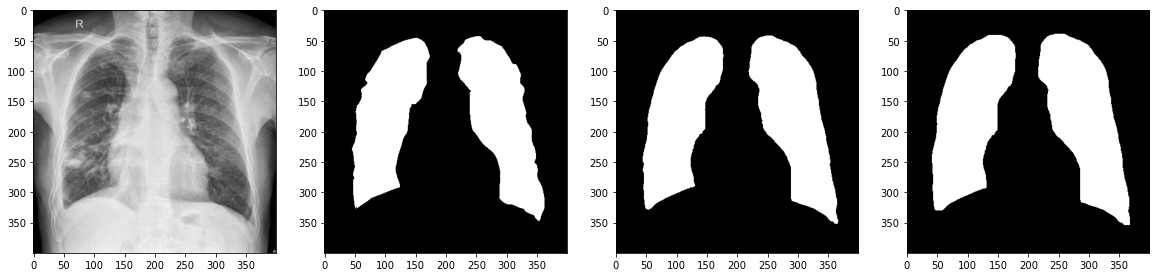

In [27]:
idx = 50
test_img = X_test[idx,:,:,:].reshape((1, img_size, img_size, 1))
test_mask = Y_test[idx,:,:,:].reshape((1, img_size, img_size, 1))
pred_mask = model.predict(test_img)
pred_mask = np.uint8(pred_mask > 0.5)
post_pred_mask = skimage.morphology.erosion(pred_mask[0,:,:,0], skimage.morphology.square(5))
post_pred_mask = skimage.morphology.dilation(post_pred_mask, skimage.morphology.square(10))

f = plt.figure(figsize = (20, 10))
f.add_subplot(1, 4, 1)
plt.imshow(img_as_ubyte(test_img[0,:,:,0]), cmap = "gray")
f.add_subplot(1, 4, 2)
plt.imshow(test_mask[0,:,:,0], cmap = "gray")
f.add_subplot(1, 4, 3)
plt.imshow(pred_mask[0,:,:,0], cmap = "gray")
f.add_subplot(1, 4, 4)
plt.imshow(post_pred_mask, cmap = "gray")

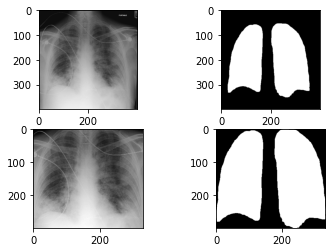

In [29]:
def crop_image(img, mask):
  crop_mask = mask > 0
  m, n = mask.shape
  crop_mask0, crop_mask1 = crop_mask.any(0), crop_mask.any(1)
  col_start, col_end = crop_mask0.argmax(), n - crop_mask0[::-1].argmax()
  row_start, row_end = crop_mask1.argmax(), m - crop_mask1[::-1].argmax()
  return img[row_start:row_end, col_start:col_end], mask[row_start:row_end, col_start:col_end]
  
#idx = 70
idx = 68
test_img = X_test[idx,:,:,:].reshape((1, img_size, img_size, 1))
test_mask = Y_test[idx,:,:,:].reshape((1, img_size, img_size, 1))
pred_mask = model.predict(test_img)[0,:,:,0]
pred_mask = np.uint8(pred_mask > 0.5)
open_pred_mask = skimage.morphology.erosion(pred_mask, skimage.morphology.square(5))
open_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))
post_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))

crop_img, crop_mask = crop_image(test_img[0,:,:,0], post_pred_mask)

crop_img_masked = crop_img * crop_mask

f = plt.figure()
f.add_subplot(2, 2, 1)
plt.imshow(img_as_ubyte(test_img[0,:,:,0]), cmap = "gray")
f.add_subplot(2, 2, 2)
plt.imshow(post_pred_mask, cmap = "gray")
f.add_subplot(2, 2, 3)
plt.imshow(img_as_ubyte(crop_img), cmap = "gray")
f.add_subplot(2, 2, 4)
plt.imshow(crop_mask, cmap = "gray")

In [ ]:
f = plt.figure(figsize = (20, 20))
f.add_subplot(1, 1, 1)
plt.imshow(img_as_ubyte(test_img[0,:,:,0]), cmap = "gray")
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

In [ ]:
f = plt.figure(figsize = (20, 20))
f.add_subplot(1, 1, 1)
plt.imshow(pred_mask, cmap = "gray")
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

In [ ]:
f = plt.figure(figsize = (20, 20))
f.add_subplot(1, 1, 1)
plt.imshow(open_pred_mask, cmap = "gray")
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

In [ ]:
f = plt.figure(figsize = (20, 20))
f.add_subplot(1, 1, 1)
plt.imshow(post_pred_mask, cmap = "gray")
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

In [ ]:
f = plt.figure(figsize = (20, 20))
f.add_subplot(1, 1, 1)
plt.imshow(crop_img_masked, cmap = "gray")
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

In [ ]:
f = plt.figure(figsize = (20, 20))
f.add_subplot(1, 1, 1)
plt.imshow(img_as_ubyte(test_img[5,:,:,0]), cmap = "gray")

In [30]:
source_folders = ["A1", "A2", "Cohen", "Eurorad", "Radiopedia", "RSNA", "Actualmed", "Figure1", "Kaggle_CRD"]
pathogen_folders = ["Opacity", "COVID-19", "Normal"]
dest_folder = "2_Images"

if os.path.isdir(dest_folder):
  shutil.rmtree(dest_folder)

if not os.path.isdir(dest_folder):
  os.makedirs(dest_folder)
  
if not os.path.isdir(os.path.join(dest_folder, "masks")):
  os.makedirs(os.path.join(dest_folder, "masks"))
  
for target in ["train", "test"]:
  for pathogen in pathogen_folders:
    pathogen_folder = os.path.join(dest_folder, target, pathogen)
    if not os.path.isdir(pathogen_folder):
      os.makedirs(pathogen_folder)

with tf.device("/gpu:0"):
  targets = ["train", "test"]
  for target in targets:
    pathogens = os.listdir(os.path.join(root_folder, target))
    for pathogen in pathogens:
      images = os.listdir(os.path.join(root_folder, target, pathogen))
      for image in images:
        source, _, pid, offset, _ = re.split("[_.]", image)
        img = imread(os.path.join(root_folder, target, pathogen, image))
        img = img_as_float32(img).reshape((1, img_size, img_size, 1))
        mask_pred = model.predict(img)[0,:,:,0]
        mask_pred = np.uint8(mask_pred > 0.5)
        mask_pred = skimage.morphology.erosion(mask_pred, skimage.morphology.square(5))
        mask_pred = skimage.morphology.dilation(mask_pred, skimage.morphology.square(10))
        img = img_as_ubyte(img[0,:,:,0])

        crop_img, crop_mask = crop_image(img, mask_pred)
        
        mask_filename = "%s_%s_%s_%s_%s.png" % (target, source, pathogen, pid, offset)
        img_filename = "%s_%s_%s_%s.png" % (source, pathogen, pid, offset)

        wdt, hgt = crop_img.shape
        if wdt < 200 or hgt < 200:
          print(img_filename)
          #continue

        crop_img = crop_img * crop_mask

        crop_img = cv2.resize(crop_img, (300, 300), interpolation = cv2.INTER_CUBIC)
        crop_mask = cv2.resize(crop_mask, (300, 300), interpolation = cv2.INTER_CUBIC)

        imsave(os.path.join(dest_folder, "masks", mask_filename), crop_mask * 255)
        imsave(os.path.join(dest_folder, target, pathogen, img_filename), crop_img)

RSNA_Normal_372_0.png
RSNA_Normal_757_0.png
RSNA_Normal_82_0.png
RSNA_Normal_759_0.png
RSNA_Normal_197_0.png
RSNA_Normal_16_0.png
RSNA_Normal_790_0.png
RSNA_Normal_222_0.png
RSNA_Normal_178_0.png
RSNA_Normal_531_0.png
RSNA_Normal_582_0.png
RSNA_Normal_653_0.png
RSNA_Normal_675_0.png
RSNA_Normal_512_0.png
RSNA_Normal_625_0.png
RSNA_Normal_74_0.png
RSNA_Normal_349_0.png
RSNA_Normal_864_0.png
Cohen_COVID-19_162_0.png
Cohen_COVID-19_198_8.png
Cohen_COVID-19_164_2.png
Cohen_COVID-19_164_1.png
RSNA_Opacity_2843_0.png
RSNA_Opacity_2501_0.png
RSNA_Opacity_2003_0.png
RSNA_Opacity_2069_0.png
RSNA_Opacity_2753_0.png
RSNA_Opacity_2211_0.png
RSNA_Opacity_2715_0.png
RSNA_Opacity_2670_0.png
RSNA_Opacity_2601_0.png
RSNA_Opacity_2587_0.png
RSNA_Opacity_2562_0.png
RSNA_Opacity_2716_0.png
RSNA_Opacity_2320_0.png
RSNA_Opacity_2210_0.png
RSNA_Opacity_2177_0.png
RSNA_Opacity_2539_0.png
RSNA_Opacity_2777_0.png
RSNA_Opacity_2247_0.png
RSNA_Opacity_2325_0.png
RSNA_Opacity_2061_0.png
RSNA_Opacity_2450_0.png
RSN